# Basic Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate the basic features of a `bayes_spec` model.

In [1]:
# General imports
from IPython.display import SVG, display
    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "svg"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

bayes_spec version: 1.3.0


## Model Definition

First, we define our model. Here we demonstrate a simple Gaussian line profile model where each "cloud" is expected to produce one Gaussian features. We follow "good" practices by ensuring that the free parameters of the model are normalized so that we are able to efficiently sample the parameter space later. To define a model, we extend the `bayes_spec.BaseModel` class. This class must have three methods: `__init__`, `add_priors`, and `add_likelihood`. This model is copied directly from `bayes_spec.models.gauss_line.py`.

In [2]:
from typing import Iterable

import numpy as np
import pymc as pm

from bayes_spec import BaseModel
from bayes_spec.utils import gaussian


class GaussLine(BaseModel):
    """
    Definition of a Gaussian line profile model.
    """

    def __init__(self, *args, **kwargs):
        """
        Define model parameters, deterministic quantities, posterior
        clustering features, and TeX parameter representations.

        Inputs: see bayes_spec.BaseModel

        Returns: new GaussLine instance
        """
        # Initialize BaseModel
        super().__init__(*args, **kwargs)

        # Define (normalized) cloud free parameter names
        self.cloud_params += [
            "line_area_norm",
            "fwhm_norm",
            "velocity_norm",
        ]

        # Define deterministic quantities (including un-normalized parameters)
        self.deterministics += [
            "line_area",
            "fwhm",
            "velocity",
            "amplitude",
        ]

        # Select features used for posterior clustering
        self._cluster_features += [
            "velocity",
            "line_area",
        ]

        # Define TeX representation of each parameter
        self.var_name_map.update(
            {
                "line_area": r"$\int\!T_B\,dV$ (K km s$^{-1}$)",
                "fwhm": r"$\Delta V$ (km s$^{-1}$)",
                "velocity": r"$V_{\rm LSR}$ (km s$^{-1}$)",
                "amplitude": r"$T_B$ (K)",
            }
        )

    def add_priors(
        self,
        prior_line_area: float = 100.0,
        prior_fwhm: float = 25.0,
        prior_velocity: Iterable[float] = [0.0, 25.0],
        prior_baseline_coeff: float = 1.0,
    ):
        """
        Add priors to the model.

        Inputs:
            prior_line_area :: scalar
                Prior distribution on line area (K km s-1), where:
                line_area ~ Gamma(alpha=2.0, beta=1.0/prior_line_area)
            prior_fwhm :: scalar
                Prior distribution on line area (K km s-1), where:
                line_area ~ Gamma(alpha=2.0, beta=1.0/prior_line_area)
                Mode of the k=2 gamma distribution Gaussian FWHM line width prior
            prior_vlsr :: two-element array of scalars
                Prior distribution on line centroid velocity (km s-1), where:
                velocity ~ Normal(mu=prior_velocity[0], sigma=prior_velocity[1])
            prior_baseline_coeff :: scalar
                Prior distribution on normalized polynomial baseline coefficients, where:
                coeff ~ Normal(mu=0, sigma=prior_baseline_coeffs)

        Returns: Nothing
        """
        # add polynomial baseline priors
        super().add_baseline_priors(prior_baseline_coeff=prior_baseline_coeff)

        with self.model:
            # Line area per cloud
            line_area_norm = pm.Gamma(
                "line_area_norm", alpha=2.0, beta=1.0, dims="cloud"
            )
            line_area = pm.Deterministic(
                "line_area", prior_line_area * line_area_norm, dims="cloud"
            )

            # FWHM line width per cloud
            fwhm_norm = pm.Gamma(
                "fwhm_norm",
                alpha=2.0,
                beta=1.0,
                dims="cloud",
            )
            fwhm = pm.Deterministic("fwhm", prior_fwhm * fwhm_norm, dims="cloud")

            # Centroid velocity per cloud
            velocity_norm = pm.Normal(
                "velocity_norm",
                mu=0.0,
                sigma=1.0,
                dims="cloud",
            )
            _ = pm.Deterministic(
                "velocity",
                prior_velocity[0] + prior_velocity[1] * velocity_norm,
                dims="cloud",
            )

            # Deterministic amplitude per cloud
            _ = pm.Deterministic(
                "amplitude",
                line_area / fwhm / np.sqrt(np.pi / (4.0 * np.log(2.0))),
                dims="cloud",
            )

    def predict(self):
        """
        Predict emission spectrum from model parameters.

        Inputs: None

        Returns: predicted
            predicted :: 1-D array of scalars
                Predicted emission spectrum (K)
        """
        # Evaluate line profile model per cloud, sum over clouds
        predicted_line = gaussian(
            self.data["observation"].spectral[:, None],
            self.model["amplitude"],
            self.model["velocity"],
            self.model["fwhm"],
        ).sum(axis=1)

        # Add baseline model
        baseline_models = self.predict_baseline()
        predicted = predicted_line + baseline_models["observation"]
        return predicted

    def add_likelihood(self):
        """
        Add the likelihood to the model. The SpecData key must be "observation".

        Inputs: None
        Returns: Nothing
        """
        # Predict emission
        predicted = self.predict()

        with self.model:
            # Evaluate likelihood
            _ = pm.Normal(
                "observation",
                mu=predicted,
                sigma=self.data["observation"].noise,
                observed=self.data["observation"].brightness,
            )

## Data Format

We wish to generate some synthetic data from our model, which requires us to take a brief aside to introduce the `bayes_spec` data format. We use the `SpecData` class to pass data into `bayes_spec`.

In [3]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

Now that we have a model definition and a dummy data format, we can generate simulated observations by drawing samples from the parameter prior distributions.

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, velocity_norm]


Text(0, 0.5, 'Brightness Temperature (K)')

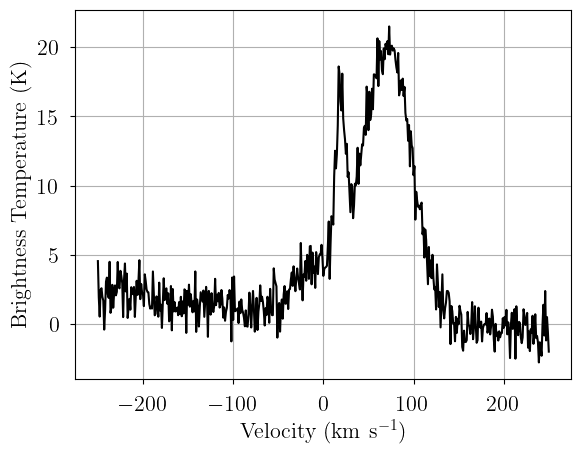

In [4]:
# Initialize and define the model
model = GaussLine(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
)
model.add_likelihood()

# Draw one posterior predictive sample
simulated = model.prior_predictive_check(
    samples=1,
)
sim_brightness = simulated.prior_predictive["observation"].sel(chain=0, draw=0).data

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

Alternatively, we can pass the relevant parameters directly to the likelihood variable, named `observation` in our model, to evaluate a model with specific model parameters. Be sure that the simulated values are reasonable given your prior distributions!

Text(0, 0.5, 'Brightness Temperature (K)')

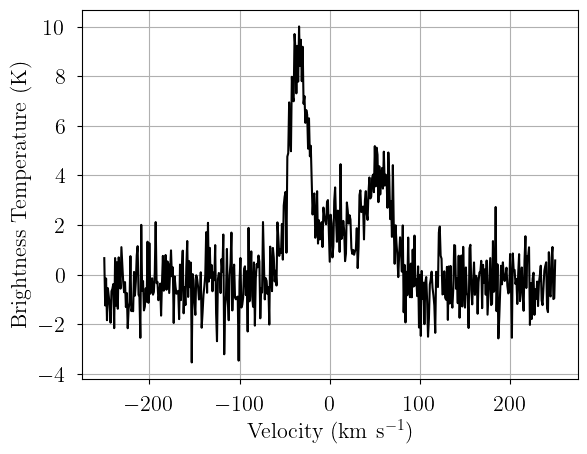

In [5]:
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "observation_baseline_norm": [-0.5, 0.2, 0.05], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [6]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `bayes_spec`.

We begin with a three-cloud (`n_cloud=3`) model, with a 2nd order polynomial baseline (`baseline_degree=2`).

In [7]:
model = GaussLine(data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
)
model.add_likelihood()

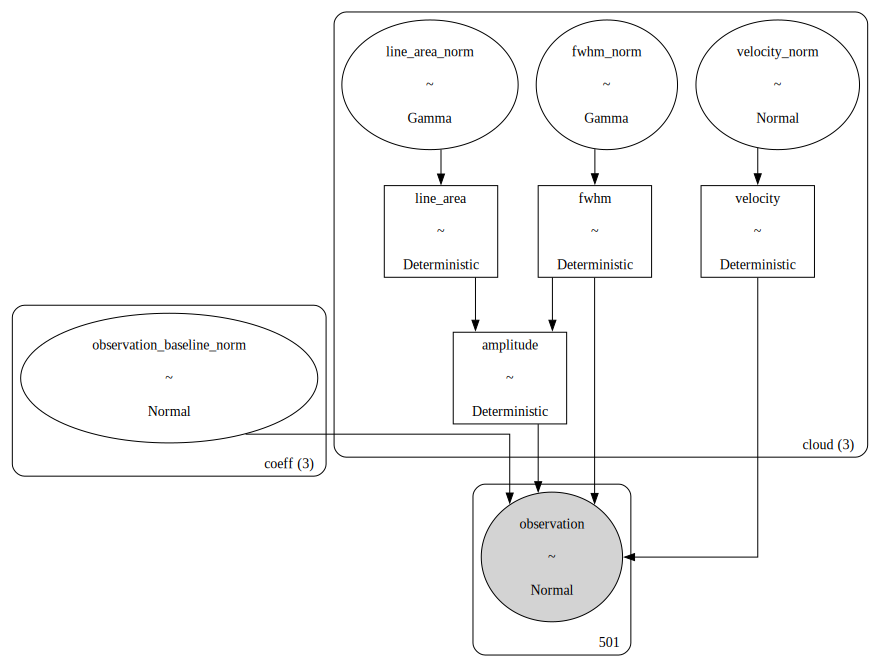

In [8]:
# Plot model graph
model.plot_graph(f"{figdir}/model.gv", "svg")
SVG(f"{figdir}/model.gv.{ext}")

In [9]:
# model string representation
print(model.model.str_repr())

observation_baseline_norm ~ Normal(0, 1)
           line_area_norm ~ Gamma(2, f())
                fwhm_norm ~ Gamma(2, f())
            velocity_norm ~ Normal(0, 1)
                line_area ~ Deterministic(f(line_area_norm))
                     fwhm ~ Deterministic(f(fwhm_norm))
                 velocity ~ Deterministic(f(velocity_norm))
                amplitude ~ Deterministic(f(fwhm_norm, line_area_norm))
              observation ~ Normal(f(fwhm_norm, line_area_norm, observation_baseline_norm, velocity_norm), <constant>)


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, velocity_norm]


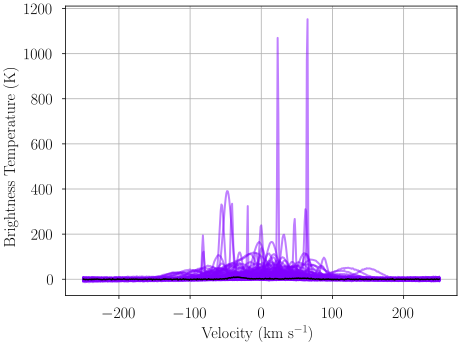

In [10]:
# prior predictive check
prior = model.prior_predictive_check(
    samples=100,  # prior predictive samples
    plot_fname=f"{figdir}/prior_predictive.{ext}",
)
SVG(f"{figdir}/prior_predictive.{ext}")

We can also generate a pair plot to inspect the prior distributions and their effect on deterministic quantities. The model has attributes `cloud_params` for cloud free parameters, `deterministics` for deterministic quantities, `baseline_params` for the free polynomial baseline parameters, and `hyper_params` for the hyperparameters. Here we show the pair plot for the deterministic quantities derived from our prior distributions.

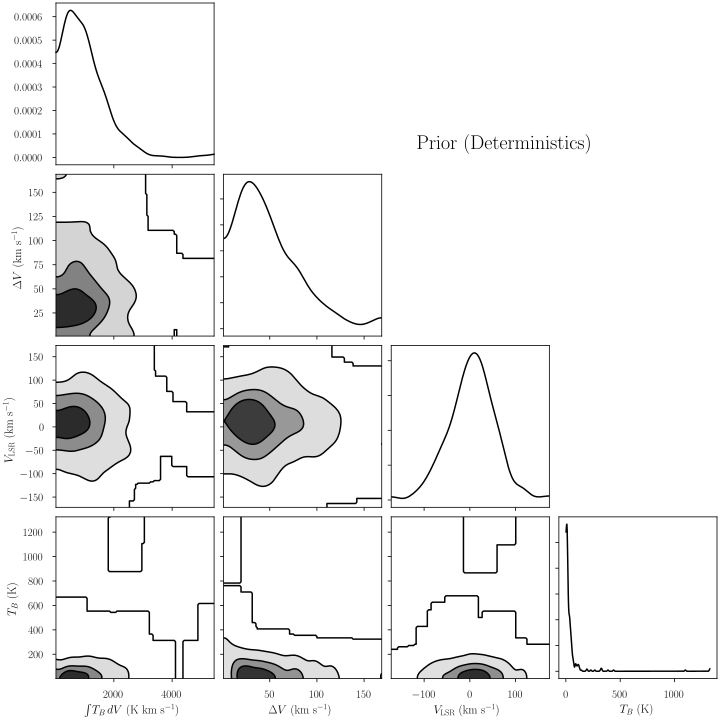

In [11]:
from bayes_spec.plots import plot_pair

plot_pair(
    prior.prior, # samples
    model.deterministics, # var_names to plot
    "Prior (Deterministics)", # plot label
    f"{figdir}/pair_prior_determ.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_prior_determ.{ext}")

## Posterior Sampling: Variational Inference

We can approximate the posterior distribution using variational inference (VI). We will run a maximum of `n` iterations, but stop early if it appears that VI has converged on a solution. You will have to tune the convergence thresholds and learning rate for your model.

In [12]:
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)

Output()

Convergence achieved at 3800
Interrupted at 3,799 [3%]: Average Loss = 3,834.5


In [13]:
# posterior samples stored in model.trace.posterior
az.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    8.231   0.441    7.435    9.043      0.015   
amplitude[1]                    4.161   0.355    3.474    4.784      0.012   
amplitude[2]                    2.408   0.239    1.985    2.859      0.008   
fwhm[0]                        22.293   0.902   20.599   23.999      0.029   
fwhm[1]                        30.506   1.954   26.786   33.922      0.064   
fwhm[2]                        76.231   5.808   65.174   86.229      0.205   
fwhm_norm[0]                    0.892   0.036    0.824    0.960      0.001   
fwhm_norm[1]                    1.220   0.078    1.071    1.357      0.003   
fwhm_norm[2]                    3.049   0.232    2.607    3.449      0.008   
line_area[0]                  195.012   6.712  182.683  207.219      0.238   
line_area[1]                  134.576   7.525  120.509  148.910      0.245   
line_area[2]                  194.224  11.412  173.758  217.867      0.366   
line_area_norm[0]               0.390   0.013    0.365    0.414      0.000   
line_area_norm[1]               0.269   0.015    0.241    0.298      0.000   
line_area_norm[2]               0.388   0.023    0.348    0.436      0.001   
observation_baseline_norm[0]   -0.463   0.023   -0.505   -0.422      0.001   
observation_baseline_norm[1]    0.034   0.038   -0.039    0.101      0.001   
observation_baseline_norm[2]    0.007   0.049   -0.082    0.099      0.002   
velocity[0]                   -35.215   0.478  -36.110  -34.334      0.015   
velocity[1]                    55.807   0.976   53.948   57.508      0.031   
velocity[2]                     2.249   2.902   -3.516    7.450      0.091   
velocity_norm[0]               -0.704   0.010   -0.722   -0.687      0.000   
velocity_norm[1]                1.116   0.020    1.079    1.150      0.001   
velocity_norm[2]                0.045   0.058   -0.070    0.149      0.002   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.011     849.0     794.0    NaN  
amplitude[1]                    0.008     892.0    1013.0    NaN  
amplitude[2]                    0.006     921.0     735.0    NaN  
fwhm[0]                         0.021     931.0     898.0    NaN  
fwhm[1]                         0.045     945.0     982.0    NaN  
fwhm[2]                         0.145     758.0     639.0    NaN  
fwhm_norm[0]                    0.001     931.0     898.0    NaN  
fwhm_norm[1]                    0.002     945.0     982.0    NaN  
fwhm_norm[2]                    0.006     758.0     639.0    NaN  
line_area[0]                    0.169     808.0     873.0    NaN  
line_area[1]                    0.174     939.0     815.0    NaN  
line_area[2]                    0.259     971.0     943.0    NaN  
line_area_norm[0]               0.000     808.0     873.0    NaN  
line_area_norm[1]               0.000     939.0     815.0    NaN  
line_area_norm[2]               0.001     971.0     943.0    NaN  
observation_baseline_norm[0]    0.001     986.0     972.0    NaN  
observation_baseline_norm[1]    0.001     954.0     948.0    NaN  
observation_baseline_norm[2]    0.001     937.0     876.0    NaN  
velocity[0]                     0.011     997.0     954.0    NaN  
velocity[1]                     0.022     960.0    1056.0    NaN  
velocity[2]                     0.067    1020.0     942.0    NaN  
velocity_norm[0]                0.000     997.0     954.0    NaN  
velocity_norm[1]                0.000     960.0    1056.0    NaN  
velocity_norm[2]                0.001    1020.0     942.0    NaN

It's good practice to verify the integrity of your solution! Here we generate posterior predictive checks -- realizations of the model drawn with parameters drawn from the posterior distribution. Each line is one posterior sample.

Sampling: [observation]


Output()

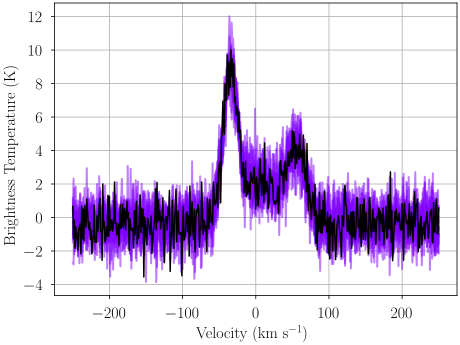

In [14]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_vi.{ext}"
)
SVG(f"{figdir}/posterior_predictive_vi.{ext}")

## Posterior Sampling: MCMC

VI is fast, but it's not particularly accurate, and there is no way to diagnose "convergence". Instead, we sample the posterior distribution using MCMC. Here we initialize the No U-Turn Sampler (NUTS) using VI (also available is the `pymc` default: `init="jitter+adapt_diag"`, which may be better suited to some models). We can customize the VI initialization as well as the NUTS parameters. If there are many divergences, or if the resulting effective sample sizes are small and `r_hat` is large, try increasing the number of tuning samples, draws, and/or chains. Increasing `target_accept` to `0.9` or `0.95` can help if there are many divergences. Use as many chains as possible.

In [15]:
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3800
Interrupted at 3,799 [3%]: Average Loss = 3,834.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


If a chain does not converge, an error is printed and that chain is dropped from all subsequent analyses. In the remaining chains, there may be some divergences. The number of divergences should be much less than the number of posterior samples.

In general, there could be a labeling degeneracy, or multiple unique solutions. Here we "solve" for those effects using a Gaussian Mixture Model (GMM). The parameter `p_threshold` defines the probability threshold for "unique" GMM solutions.

In [16]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [24]:
model.trace.solution_0

<xarray.Dataset> Size: 776kB
Dimensions:                    (chain: 4, draw: 1000, cloud: 3, coeff: 3)
Coordinates:
  * chain                      (chain) int64 32B 0 1 2 3
  * draw                       (draw) int64 8kB 0 1 2 3 4 ... 996 997 998 999
  * cloud                      (cloud) int64 24B 0 1 2
  * coeff                      (coeff) int64 24B 0 1 2
Data variables:
    amplitude                  (chain, draw, cloud) float64 96kB 9.116 ... 2.203
    fwhm                       (chain, draw, cloud) float64 96kB 22.57 ... 46.46
    fwhm_norm                  (chain, draw, cloud) float64 96kB 0.9027 ... 1...
    line_area                  (chain, draw, cloud) float64 96kB 219.0 ... 108.9
    line_area_norm             (chain, draw, cloud) float64 96kB 0.438 ... 0....
    observation_baseline_norm  (chain, draw, coeff) float64 96kB -0.4682 ... ...
    velocity                   (chain, draw, cloud) float64 96kB -35.26 ... -...
    velocity_norm              (chain, draw, cloud) float64 96kB -0.7052 ... ...
Attributes:
    created_at:     2024-08-01T18:28:33.475382+00:00
    arviz_version:  0.18.0

In [17]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    8.447   0.539    7.496    9.427      0.015   
amplitude[1]                    4.264   0.368    3.563    4.927      0.008   
amplitude[2]                    2.446   0.235    1.994    2.872      0.004   
fwhm[0]                        23.186   1.539   20.299   25.994      0.043   
fwhm[1]                        31.217   2.905   25.935   36.776      0.068   
fwhm[2]                        65.232  16.526   32.958   92.060      0.535   
fwhm_norm[0]                    0.927   0.062    0.812    1.040      0.002   
fwhm_norm[1]                    1.249   0.116    1.037    1.471      0.003   
fwhm_norm[2]                    2.609   0.661    1.318    3.682      0.021   
line_area[0]                  208.865  23.061  166.955  249.369      0.745   
line_area[1]                  141.898  19.466  107.429  179.532      0.540   
line_area[2]                  169.252  44.663   88.947  246.795      1.462   
line_area_norm[0]               0.418   0.046    0.334    0.499      0.001   
line_area_norm[1]               0.284   0.039    0.215    0.359      0.001   
line_area_norm[2]               0.339   0.089    0.178    0.494      0.003   
observation_baseline_norm[0]   -0.469   0.054   -0.573   -0.371      0.001   
observation_baseline_norm[1]    0.030   0.036   -0.037    0.098      0.001   
observation_baseline_norm[2]   -0.004   0.096   -0.176    0.178      0.002   
velocity[0]                   -35.033   0.485  -35.932  -34.108      0.011   
velocity[1]                    55.732   1.270   53.245   58.039      0.031   
velocity[2]                     3.177   5.643   -7.156   14.042      0.157   
velocity_norm[0]               -0.701   0.010   -0.719   -0.682      0.000   
velocity_norm[1]                1.115   0.025    1.065    1.161      0.001   
velocity_norm[2]                0.064   0.113   -0.143    0.281      0.003   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.011    1259.0    2773.0    1.0  
amplitude[1]                    0.006    1977.0    2514.0    1.0  
amplitude[2]                    0.003    3170.0    2825.0    1.0  
fwhm[0]                         0.030    1276.0    2008.0    1.0  
fwhm[1]                         0.048    1811.0    2637.0    1.0  
fwhm[2]                         0.378     988.0    1565.0    1.0  
fwhm_norm[0]                    0.001    1276.0    2008.0    1.0  
fwhm_norm[1]                    0.002    1811.0    2637.0    1.0  
fwhm_norm[2]                    0.015     988.0    1565.0    1.0  
line_area[0]                    0.527     980.0    1858.0    1.0  
line_area[1]                    0.382    1313.0    2153.0    1.0  
line_area[2]                    1.034     926.0    1573.0    1.0  
line_area_norm[0]               0.001     980.0    1858.0    1.0  
line_area_norm[1]               0.001    1313.0    2153.0    1.0  
line_area_norm[2]               0.002     926.0    1573.0    1.0  
observation_baseline_norm[0]    0.001    1826.0    1679.0    1.0  
observation_baseline_norm[1]    0.001    3464.0    2536.0    1.0  
observation_baseline_norm[2]    0.002    1931.0    1886.0    1.0  
velocity[0]                     0.008    1868.0    2301.0    1.0  
velocity[1]                     0.022    1656.0    2342.0    1.0  
velocity[2]                     0.111    1338.0    1763.0    1.0  
velocity_norm[0]                0.000    1868.0    2301.0    1.0  
velocity_norm[1]                0.000    1656.0    2342.0    1.0  
velocity_norm[2]                0.002    1338.0    1763.0    1.0

We again generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color, and the "thin" lines are the contributions of individual clouds. Each line is one posterior sample.

Sampling: [observation]


Output()

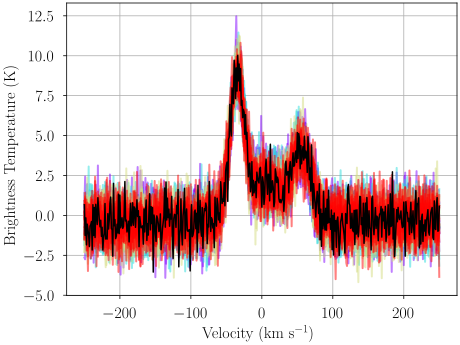

In [18]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive.{ext}"
)
SVG(f"{figdir}/posterior_predictive.{ext}")

In [19]:
model.plot_traces(f"{figdir}/traces.{ext}")
SVG(f"{figdir}/traces.{ext}")

We can inspect the posterior distribution pair plots. First, the (deterministic) cloud parameters.

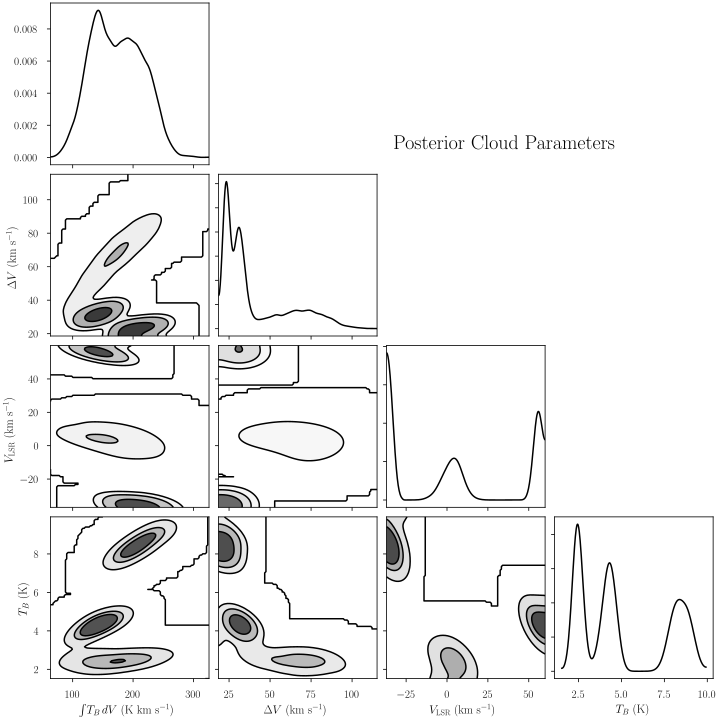

In [20]:
plot_pair(
    model.trace.solution_0, # samples
    model.deterministics, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params.{ext}")

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions for a single cloud.

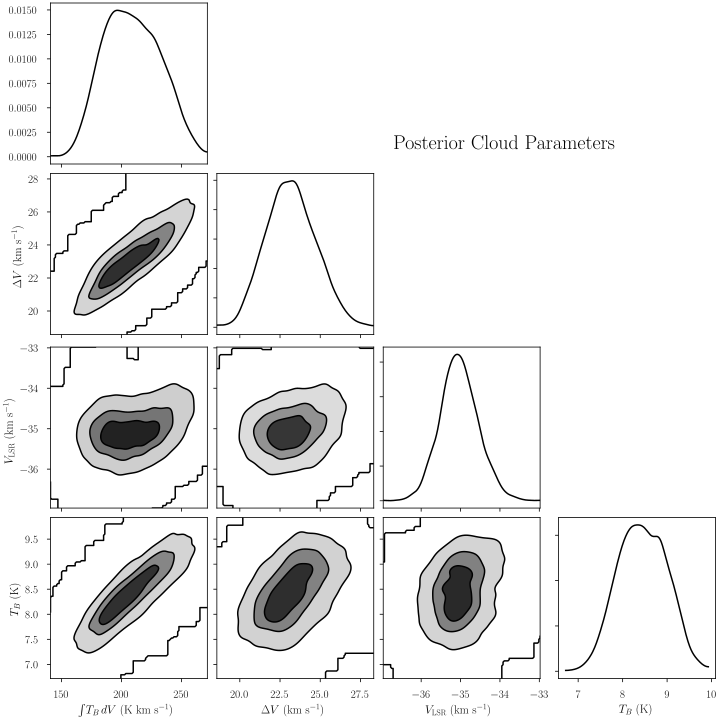

In [21]:
plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.deterministics, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params_0.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params_0.{ext}")

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [22]:
point_stats = az.summary(model.trace.solution_0, var_names=model.deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: 1500.28649750562


mean      sd  hdi_16%  hdi_84%
line_area[0]  208.865  23.061  181.888  230.733
line_area[1]  141.898  19.466  120.046  159.488
line_area[2]  169.252  44.663  118.568  212.357
fwhm[0]        23.186   1.539   21.651   24.773
fwhm[1]        31.217   2.905   28.218   33.894
fwhm[2]        65.232  16.526   48.731   83.577
velocity[0]   -35.033   0.485  -35.500  -34.571
velocity[1]    55.732   1.270   54.593   57.076
velocity[2]     3.177   5.643   -1.702    9.293
amplitude[0]    8.447   0.539    7.873    8.996
amplitude[1]    4.264   0.368    3.936    4.660
amplitude[2]    2.446   0.235    2.182    2.641